# Model Interpretation with Random Forests - Going Beyond Simple Predictions

In this notebook I share four different ways of making predictions more interpretable in a business context using LGBM and Random Forest. The goal is to go beyond using a model solely to get the best possible predictions, and to focus on gaining insights that can be used by analysts and decision makers in order to change the behavior of how a company does business, marketing, how they sell their product, etc.

I use a common data set - [Teleco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) - because it is simple and illustrates a classic business problem about growth.  

I will dive into the following methods:
- [Feature Importance](#1.-Feature-Importance)
- [Tree interpreter](#2.-Tree-Interpreter)
- [Partial dependence](#3.-Partial-Dependence)
- [Confidence based on tree variance](#4.-Confidence-Based-on-Tree-Variance)

I will apply them to our dataset, explain what they are, their use cases, how they are calculated, and interpret all the results.  

These learnings are a summary of the material used in Fastai's course [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml.html).   

# Imports and Loading the Data

In [3]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import * 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
from IPython.display import display
from sklearn import metrics
import seaborn as sns

In [5]:
telecom_cust = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
telecom_cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Quick Cleaning and Encoding

A lot of our variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required to run our models. Therefore, we create `train_cats` function to convert strings to pandas categories. We'll also drop the `customerID` column which will not be useful for prediction.

In [66]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [67]:
# Drop customerID which is not useful for prediction
telecom_cust.drop(['customerID'], axis=1, inplace=True)

In [68]:
# Apply train_cats
train_cats(telecom_cust)

In order to quickly clean and numericalize our data to make it ready for training, we use a handy function from Fastai which is `proc_df`. I won't go into the details but it basically takes a data frame, splits off the response variable (y), and changes the df into an entirely numeric dataframe by converting the category columns to their matching category codes. For each column of df, NaN values are replaced by the median value of the column.

Passing ` max_n_cats=5` to the function will OneHotEncode categories with 5 or less unique values.

In [69]:
df_trn, y_trn, nas = proc_df(telecom_cust, 'Churn', max_n_cat=5)

In [70]:
df_trn

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,gender_nan,Partner_No,Partner_Yes,Partner_nan,...,Contract_Two year,Contract_nan,PaperlessBilling_No,PaperlessBilling_Yes,PaperlessBilling_nan,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_nan
0,0,1,29.85,2506,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0,34,56.95,1467,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,2,53.85,158,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,45,42.30,1401,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,2,70.70,926,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1598,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
7039,0,72,103.20,5699,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
7040,0,11,29.60,2995,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
7041,1,4,74.40,2661,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


We now have a DataFrame that is ready for training. Let's move on to the purpose of this notebook: model interpretation. 

# 1. Feature Importance

**What is it used for?**

Understanding which features have the most impact on our model.

**Use cases**

- Feature selection: We can eliminate from our model the features which had very low to no importance at all. Removing features in this  way usually results in a better prediction in our model. Always test if this is the case. 
- Exploratory data analysis: Once we know the most important features, we can focus on understanding these features in much more depth. We should visualize their distribution, see how they are related to each other, and to the target variable, as well as other EDA methods. 
- Data collection: Once you know which features best predicts something, we can focus on better collecting those variables for future observations. 

**How is it calculated?**

1. Take a feature of our DataFrame and randomly shuffle its values - this feature is now useless in terms of predicting power. 
2. We then look at the score we are interested in (RMSE, R^2, etc) and see how it was impacted after the shuffling. 
3. We keep track of the new score, and repeat the process for all features and scores. 
4. To calculate the importance of a feature, we take the difference between the initial model's score, and score after having shuffled the feature. Repeat for all features. 

**Important notes**

- The attribute `important_features` is given by default in almost all tree based models. However, this is applicable to __all__ models if we code the process ourselves. 
- This is calculated without needing to retrain our Random Forest each time. We are simply calculating predictions which makes it convenient and easy to use.   
- It is important to look at the relative importance of the features when interpreting them. If our top 5 features' score are 100x more than all the others, it is not worth spending much time on the other features. 


## LightGBM's feature importance

### Train the model

In [71]:
# Create a random training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, y_trn, test_size=0.2, random_state=101)

In [72]:
# Parameters we are using for LGBM
params = {'num_leaves': 400,
          'min_child_weight': 0.03,
          'feature_fraction': 0.4,
          'bagging_fraction': 0.6,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.001,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.4,
          'reg_lambda': 0.6,
          'random_state': 47,
          'max_bin': 500
         }

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

%time clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.860292	valid_1's auc: 0.841668
[400]	training's auc: 0.861686	valid_1's auc: 0.842002
[600]	training's auc: 0.863651	valid_1's auc: 0.842175
[800]	training's auc: 0.865105	valid_1's auc: 0.842295
[1000]	training's auc: 0.866721	valid_1's auc: 0.842674
[1200]	training's auc: 0.868143	valid_1's auc: 0.842715
[1400]	training's auc: 0.869604	valid_1's auc: 0.842749
[1600]	training's auc: 0.871004	valid_1's auc: 0.842663
[1800]	training's auc: 0.872438	valid_1's auc: 0.842533
Early stopping, best iteration is:
[1436]	training's auc: 0.869882	valid_1's auc: 0.842856
Wall time: 3.71 s


## Plot top feature importance

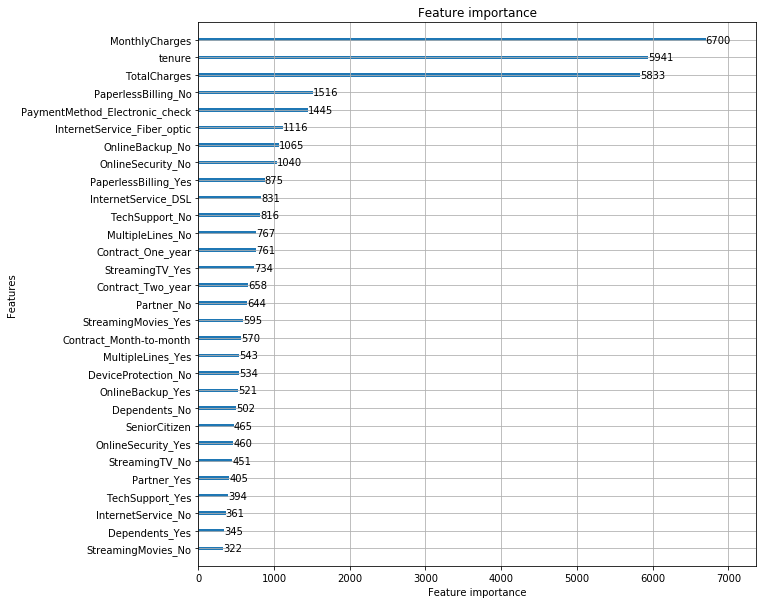

In [92]:
lgb.plot_importance(clf, figsize=(10,10), max_num_features=30)

In [74]:
# Create a function to get feature importance
def feature_importance(df, m):
    fi = pd.DataFrame({'cols': df.columns, 'feature-importances': m.feature_importance(importance_type='split')})\
                        .sort_values(by='feature-importances', ascending=False)
    return fi

fi = feature_importance(df_trn, clf)

We can visualize the distribution of feature importance. Only 3 are very important, and some have little to no importance at all.

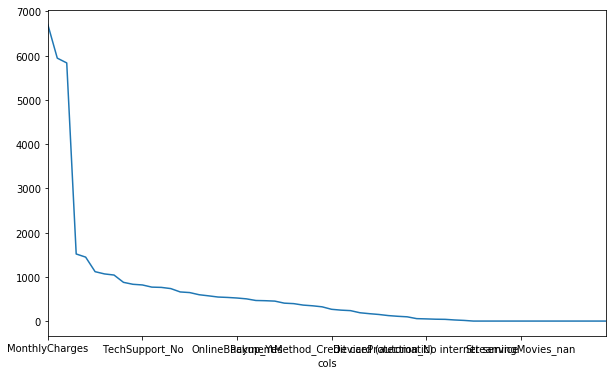

In [75]:
fi.plot('cols', 'feature-importances', figsize=(10,6), legend=False);

## Keep features with importance > 100 only 

Let's get rid of the features that had low to no importance at all to make our DataFrame simpler. This also increased our accuracy by 0.1. 

In [76]:
# Keep only the columns with over 80 importance
df_keep = fi[fi['feature-importances'] > 100]

df_trn = df_trn[df_keep.cols]
df_trn.shape

(7043, 38)

## **Interpretation**

Three features really stand out: ` MonthlyCharges`, `TotalCharges` and `tenure`. We should make sure to deeply analyze them.
Other features worth looking at: `PaymentMethod_Eletronic Check`, `InternetService_Fiber_optic`, `PaperlessBilling_No`, etc.. all the way down to at least `PaperlessBilling_Yes`. 

# 2. Tree Interpreter 

**What is it used for?**

Let's say a company has built a model that predicts the likelihood of a customer churning within the next month. 

What if, after our model predicts that a customer will churn at a 80% probability, we want to understand __why__ the model made this prediction? What features contributed the most to output this decision? 

Or what if our model works as expected on an old data set, but is producing unexpected results on a new one? How would we go about interpreting this change of behavior? 

While calculating feature importance is a great way to get a sense of what has the most influence on a model, it gives little insight in understanding individual decisions on data. 

This is exactly what the tree interpreter library allows us to do. Every prediction can be presented as a sum of feature contributions, showing how the features lead to a particular prediction. 

**Use cases**

This opens up a lot of opportunities in practical machine learning and data science tasks:

- Explain to a manager why a particular prediction is made.
- Debug models when results are unexpected.

**How is it calculated?**

Using tree interpreter, each prediction is decomposed into 3 components: prediction, bias, and feature contribution. 
- The prediction: from the Random Forest.
- The bias: average churn probability across the whole original dataset. It is the average of the root node before we start doing any splits. 
- The Contributions: average of the increase or decrease in churn caused by 1 feature, for all our trees in the Random Forest. 

In other words, for a dataset with `n` features, each prediction on the dataset is decomposed as `prediction = bias + feature_1_contribution + feature_2_contribution + ... + feature_n_contribution`.


**Important notes**

- These insights are very useful inside a production environment. 
- We can use tree interpreter alongside managers and subject matter experts to test a few observations and check if the model looks intuitive and makes sense. 

## Train our Random Forest

In [91]:
# Create training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, y_trn, test_size=0.2, random_state=101)

# Train the Random Forest model
model_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1,
                                  random_state=50, max_features=0.3, min_samples_leaf=10,
                                  max_leaf_nodes=30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_valid)
print(metrics.accuracy_score(y_valid, prediction_test))

0.7927608232789212


## Fetch the values of a row from our data

In [31]:
from treeinterpreter import treeinterpreter as ti

In [46]:
# Get the values of the columns of the row at index 3
row = X_valid.values[None,3]; row

array([[ 50.15,   2.  , 286.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ,   1.  ,   1.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ,   1.  ,   1.  ,   1.  ,   0.  ,
          1.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
          0.  ,   0.  ]])

## Find the contributions of each feature for that row

In [47]:
# Pass our random forest model and our row to treeinterpreter.predict()
prediction, bias, contributions = ti.predict(model_rf, row)

In [48]:
# Get our prediction of churn for this customer, as well as the bias
prediction[0], bias[0]

(array([0.60347, 0.39653]), array([0.73607, 0.26393]))

In [49]:
# Sort the features based on their contributions
idxs = np.argsort(contributions[0][:][:,1])
idxs

array([ 5,  0,  6,  9,  4, 20,  2,  3,  8, 30, 11, 15, 25, 34, 37, 35, 16, 18, 31, 13, 28, 21, 29, 33, 24,
       19, 32, 27, 26, 12, 36, 23, 14, 22, 10,  7, 17,  1], dtype=int64)

In [50]:
# zip column names from 'df_trn', the values of the columns from 'X_valid' 
# and the contributions of our features from 'contributions'. Pass [idxs] to all
[o for o in zip(df_trn.columns[idxs], X_valid.iloc[4][idxs], contributions[0][:][idxs,1])]

[('InternetService_Fiber optic', 1.0, -0.055946763569011834),
 ('MonthlyCharges', 73.65, -0.03085270244048489),
 ('OnlineBackup_No', 1.0, -0.02587489259682273),
 ('InternetService_DSL', 0.0, -0.024697558274560216),
 ('PaymentMethod_Electronic check', 1.0, -0.017161760620752694),
 ('OnlineBackup_Yes', 0.0, -0.016517884179024736),
 ('TotalCharges', 5670.0, -0.015604631787593172),
 ('PaperlessBilling_No', 0.0, -0.012545510070272776),
 ('PaperlessBilling_Yes', 1.0, -0.011216201105208731),
 ('PaymentMethod_Credit card (automatic)', 0.0, -0.005752565230849388),
 ('MultipleLines_No', 0.0, -0.0038219448148636816),
 ('Partner_No', 1.0, -0.003050086723524375),
 ('Partner_Yes', 0.0, -0.0019104396205741286),
 ('gender_Female', 0.0, -0.0017446471550967874),
 ('gender_Male', 1.0, -0.0012592725497145097),
 ('DeviceProtection_Yes', 0.0, -0.0007374995801911572),
 ('StreamingMovies_Yes', 0.0, -0.0006943936548643692),
 ('MultipleLines_Yes', 1.0, -0.0006901056161433448),
 ('PaymentMethod_Mailed check', 0.

## Verify that prediction = bias + feature contributions

In [58]:
# sum of our contributions
contributions[0][:][:,1].sum() 

0.13259928529016457

In [53]:
# The sum of our contributions + the bias should equal our prediction
contributions[0][:][:,1].sum() + bias[0][1]

0.3965270453185636

In [54]:
prediction[0][1]

0.3965270453185635

## Interpretation

Our prediction for this particular observation is a 39.65% chance of churn. If someone asks why we're not so sure about our prediction, we have the information to answer this question.

Let's look at our top 3 contributions that increases the likelihood of churn, copy-pasted from above:

- ('tenure', 1.0, 0.14946106977749185)
- ('Contract_Month-to-month', 1.0, 0.07450000863313583)
- ('OnlineSecurity_No', 1.0, 0.05019770357328585)

Now our top 3 contributions that decrease the likelihood of churn:

- ('InternetService_Fiber optic', 1.0, -0.055946763569011834),
- ('MonthlyCharges', 73.65, -0.03085270244048489),
- ('OnlineBackup_No', 1.0, -0.02587489259682273)

We can se that this customer hasn't been around for a long time with a `tenure` of only 1.0 month. This increases our model's churn prediction by 0.149. This customer also has a contract type of `Month-to-month`. This increases our model's churn prediction by 0.074. We also know that they don't have `OnelineSecurity` which increases churn by 0.05. 

However, they have `InternetService_Fiber optic`, `MonthlyCharges` of 73.65\$, and no `OnlineBackup` which all contribute to lowering the customer's likelihood of churn. 

Given this information, maybe we're interested in putting some effort in retaining this customer because we want to increase our users with Fiber optic internet. Or maybe it's the opposite, we've realized that it is not worth prioritizing efforts on a customer paying month-to-month and who's been with the company for a short period of time given our limited resources in the customer service team. Whatever the case will be, we now have much more data to inform our decision. 

# 3. Partial Dependence

**What is it used for?**

With partial dependence, we want to know the relationship between a feature and the target variable all other things being equal. In other words, we consider only the feature under consideration to be varying, ensuring all the other features remain constant. Thus we cut out the noise from other dependent variables, removing any collinearity, and get a better understanding of the true nature of interactions of each feature with the target variable.


**Use cases**

- Understand the true nature between variables and go past the limitations of simple univariate or bivariate plots.  
- Understand interactions between 2 variables and the target variable by plotting their relationship.

Examples of both are shown below. 

**How is this calculated?**

Example of a partial dependence plot with the pdp library. The x axis is `MonthlyCharges` and the y axis is the probability of churn:

<img src="data/monthlycharges-partial-dependance-plot.png">

- In a partial dependance plot, every blue line represents one row in our dataset (one customer). The black line represents the average of all the blue lines.

- Keeping all other columns (feature values) constant, we keep looping through all the unique values of the feature we're considering (`MonthlyCharges` in the example above), and run a Random Forest model to predict results for each unique value of this feature. 

- We plot the resulting values to understand the trend behind the way the target variable varies with this particular feature and for each row we are looking at.


**Analysis**

In the following analysis, we will look at getting a better understanding of the relationships between:
- `MonthlyCharges` and `Churn`
- `tenure` and `Churn`
- `Contract` types and `Churn`
- `MonthlyCharges` + `tenure` and `Churn`

## Import pdp library and get a random sample to work with

In [78]:
from pdpbox import pdp
from plotnine import *
from plotnine.data import mpg

In [79]:
# Work on a sample of the data for our visualizations
rand_sample = np.random.permutation(len(telecom_cust))[:500]
df_sample = telecom_cust.iloc[rand_sample]

In [80]:
# We work  on our telecom_cust DataFrame. First we convert 
telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')

## MonthlyCharges and Churn

### Univariate plot

Let's first look at the `MonthlyCharges` distributions of Churned and Not Churned customers. 

Text(0.5,1,'Distribution of monthly charges by churn')

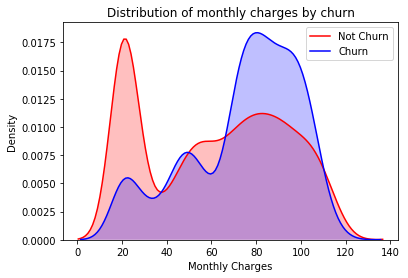

In [83]:
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

Looking at the distributions of Churned and Not Churned customers, we can see that higher `MonthlyCharges` seem to correlate with higher churn.

### Partial dependence plot

In [84]:
# Use the pdp library and define a plot_pdp function for our PDP visualization
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model_rf, df_trn.iloc[rand_sample], feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

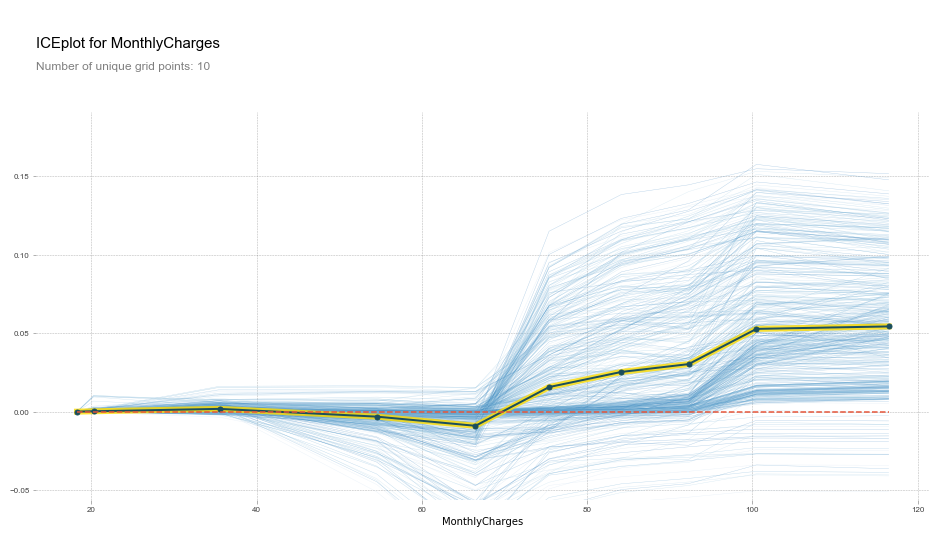

In [31]:
plot_pdp('MonthlyCharges')

### Partial Dependence Plot Interpretation

This plot shows us that, all other things being equal, when `MonthlyCharges` is over 65\\$, there is on average a spike in churn probability. Below 65$, churn probability decreases slightly. 

This is what we expected given the univariate plot given above, but this PDP gives us more information.

Since every blue line represents 1 row (or 1 customer), we can see that `MonthlyCharges` affects people differently. We can see that some customers would be affected by an increase in `MonthlyCharges`, while others would barely be affected. 

To see this more clearly, we can add clusters to our PDP function to group together clients that are affected in the same way by `MonthlyCharges`. 

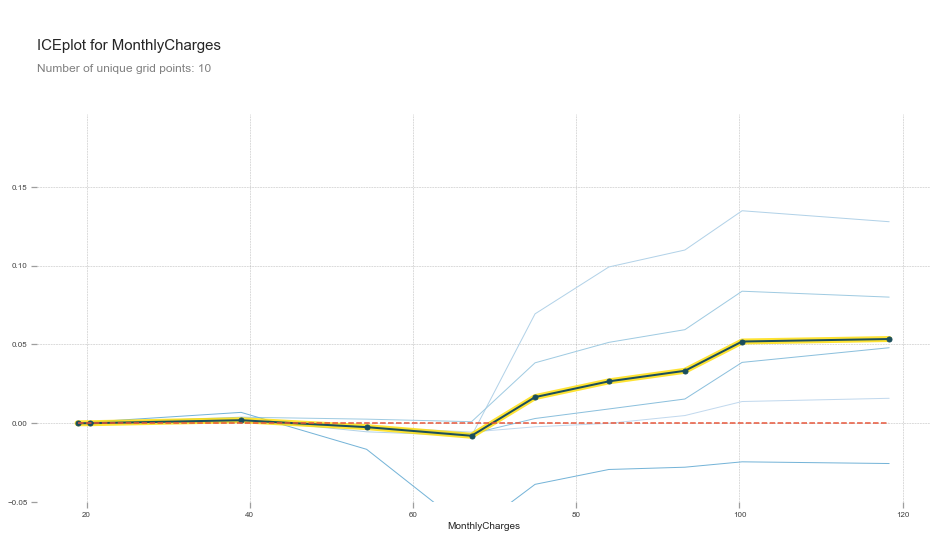

In [630]:
plot_pdp('MonthlyCharges', clusters=5)

When `Monthly Charges` is over 65$, there are two groups of customers that are negatively affected. There are also 2 other groups that are not affected. 

This means that we would safely upsell one group, and that we could try to reduce the monthly charges for the other group to increase customer retention. 

## Tenure and Churn

### Univariate plot

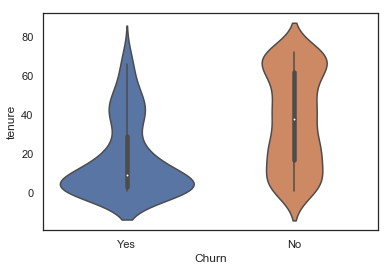

In [775]:
sns.violinplot(data=telecom_cust.iloc[rand_sample], x='Churn', y='tenure')

Looking at the lower part of the blue violin plot (churned customers), one could think that there is a positive correlation with how recent a customer is and the churn likelihood. 

However, the partial dependence plot tells another story:

### Partial dependence plot

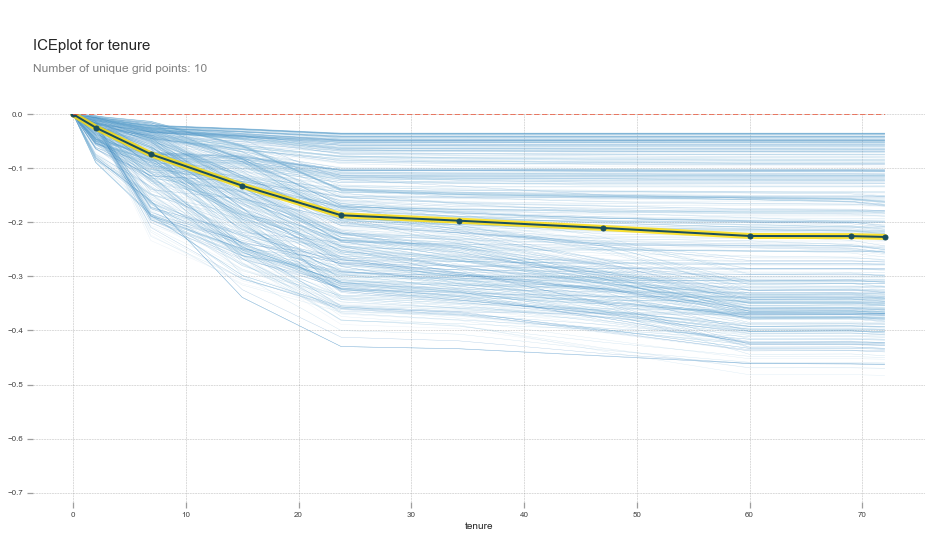

In [609]:
plot_pdp('tenure')

### Partial dependance plot interpretation

`tenure` has a negative relationship with churn right from month 0. The relationship is stronger from 0 to 25 months, and then gets weaker as months increase. 

This is actually what we would expect from `tenure` all things being equal. `tenure` alone does not increase someone's likelihood of churn. It is when there is an interaction between low `tenure` and high `MonthlyCharges` or `tenure` and a `Month-to-month` contract that we see an increase in churn.

Let's look at these interactions with pdp's interact plot. 

## Contract Values and Churn

When plotting a partial dependence plot, we can also pass multiple variables. For instance, we could use ones that we previously OneHotEndoded such as `Contract`.

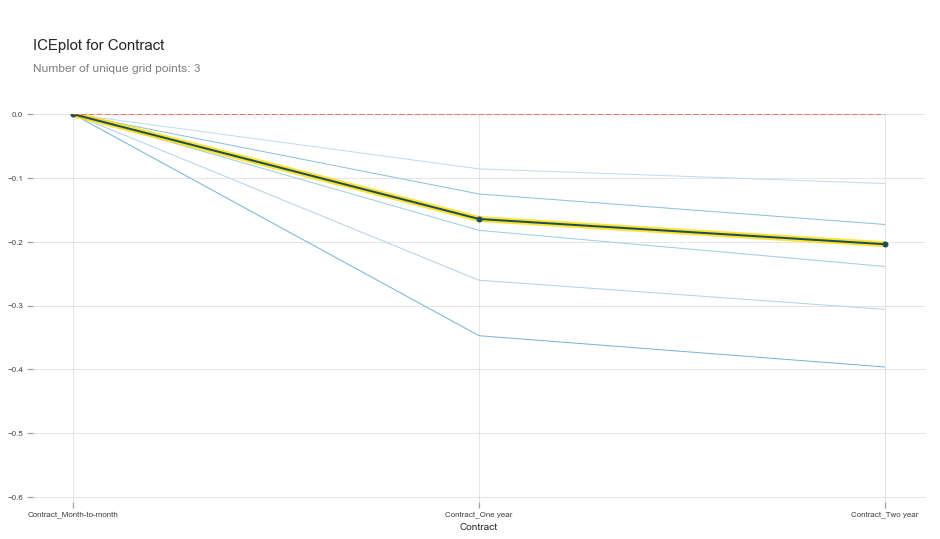

In [625]:
plot_pdp(['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year'], 5, 'Contract')

This shows that all else being equal, `One_year` and `Two_year` contracts reduces the chances that a customer will churn. 

## Interaction between MonthlyCharges + Tenure and Churn

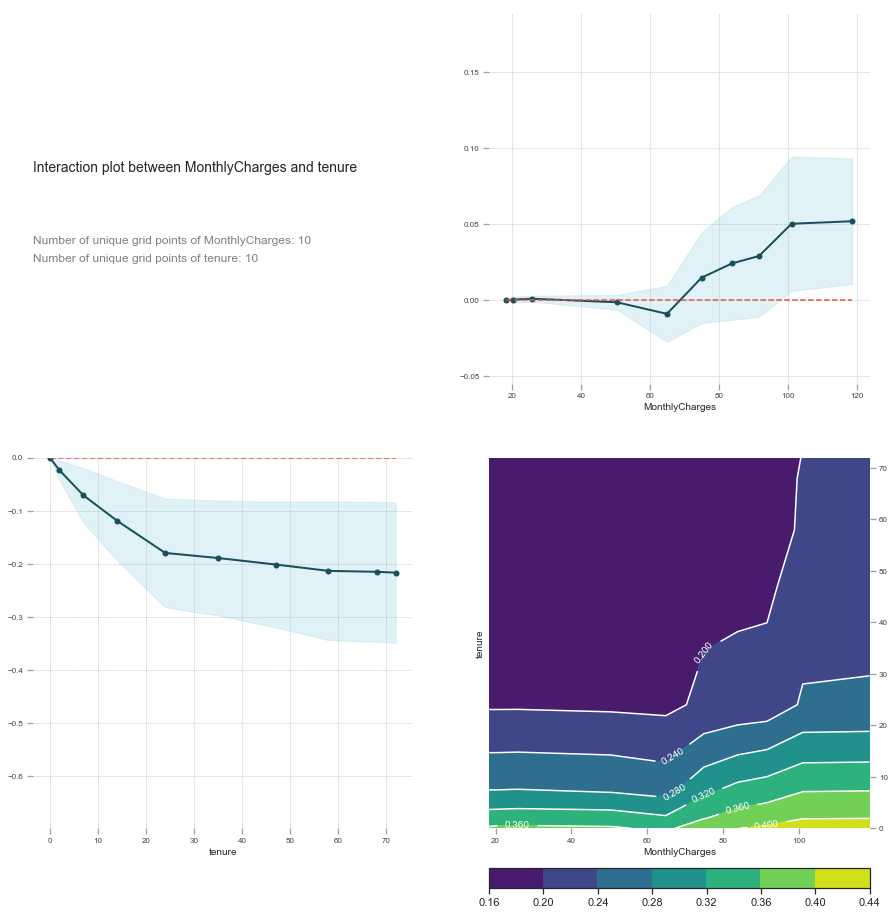

In [629]:
feats = ['MonthlyCharges', 'tenure']
p = pdp.pdp_interact(model_rf, df_trn, feats)
pdp.pdp_interact_plot(p, feats)

### Interaction interpretation

We saw previously that `tenure` alone does not negatively influence churn. By looking at the interaction between `MonthlyCharges` and `tenure` we see that the relationship is linear at first, but then low `tenure` and high `MonthlyCharges` increasingly affects churn. 

Since our interaction plot shows that the two together potentially has a predicting power of 0.44 at most (indicated by the score), we know that this is a big indicator for determining whether a customer will churn or not. 

## Create an interaction between `MonthlyCharges` and `tenure`

In [85]:
df_trn['MonthlyCharges_tenure']= df_trn['tenure']/df_trn['MonthlyCharges']

### Retrain the model and get feature importance

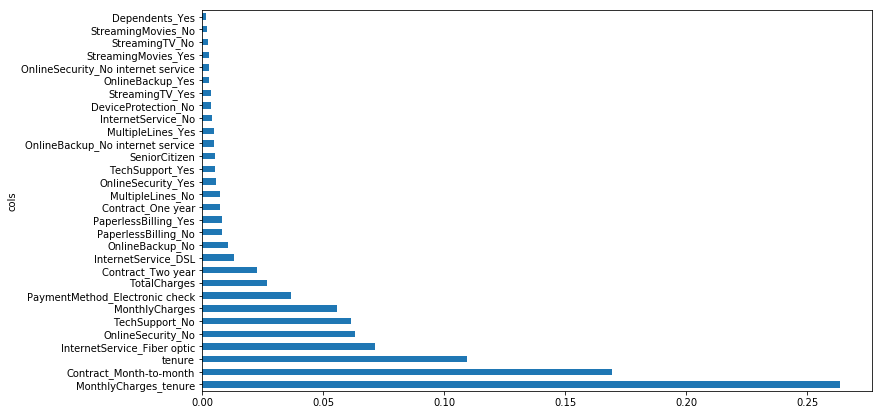

In [89]:
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, y_trn, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1,
                                  random_state=50, max_features=0.3, min_samples_leaf=10,
                                  max_leaf_nodes=30)
model_rf.fit(X_train, y_train)

fi = rf_feat_importance(model_rf, df_trn); fi[:10]
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

### Interpretation

Adding this interaction has allowed us to get a new feature with the highest importance which can now be used for better interpretation. 

>Note: this should not be our final model. This is simple an example of one possible interaction. More feature engineering is needed.

# 4. Confidence Based on Tree Variance

**What is it used for?**

This tells us the *relative* confidence of our predictions by taking the __standard deviation of the predictions of our trees__, instead of using the mean of all the trees in our Random Forest. In other words, for rows where the trees of our Random Forest give very different predictions, we would want to be more cautious of using those results compared to cases where they are more consistent. 

If we're putting out an algorithm which is making big decisions that could cost a lot of money if it were wrong, we probably don't care about the average prediction of the model. We're more likely to care about the average prediction, minus a few standard deviations. 

Here is a quick refresher of how Random Forests work:

<img src="data/randomforest.png" width="500" height="600">


**Use cases**

With confidence based on tree variance, we are interested in two things: 
1. Analyzing single observation interpretations. We take one row, one observation, and check how confident we are about it. To do so we check how much variance is there in the prediction of all our trees in the Random Forest.
> __Example__: Is customer X a good or a bad risk? Should we loan her 1 million\$? Our model might tell us that this customer is good risk, but maybe it's not at all confident about that prediction. In which case maybe the best thing to do is to not give her 1 million\\$.

2. Groups of observations we are unconfident about. 
>__Example__: When someone has a `Contract` of type `Month-to-month`, we're never confident about our predictions. 

**How is it calculated?**

As alluded to earlier, rather than taking the mean as our prediction, what if we took the standard deviation of the predictions of the trees?

If it's high, then each tree is giving us a very diff estimate of this observation's prediction. If this was a very common kind of row, the trees would have learned to make a good prediction on it because it will have learned how and where to split in the trees. 

Therefore, **the standard deviation of the predictions gives us some understanding of how confident we are of this prediction.** 

**Important notes**

- We might be less confident in our prediction if we haven't seen many observations that are similar to the one we're interested in. If that's the case, then we wouldn't expect any of our trees to have a path which is designed to help us predict the observation we're interested in. As such, we would expect that when we pass that observation through our different trees, it is going to end up in different places with different predictions.  
- This does not exist in scikit learn or any other library so we have to build it. 
- The result of this analysis should tell us if there are some observations or groups that we are not confident about. This should then change our decision process on how the company approaches churn.  

## Create our Random Forest with 1000 trees

In [77]:
# Create training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, y_trn, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1,
                                  random_state=50, max_features=0.3, min_samples_leaf=10,
                                  max_leaf_nodes=30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_valid)
print(metrics.accuracy_score(y_valid, prediction_test))

0.7963094393186657


In [22]:
# Replace Churn values to 1 and 0 in order to get an average later
telecom_cust['Churn'].replace(to_replace='Yes', value=1, inplace=True)
telecom_cust['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [23]:
# Get the probabilities of churn for each tree in our model
preds = np.stack([t.predict_proba(X_valid)[:,1] for t in model_rf.estimators_])

`np.stack` is used to concatenate our predictions to a new axis. Our **rows** are the results/predictions for each tree. We made a Random Forest of `n_estimators=1000` so we'll have 1000 rows. Our **columns** are the results of each observation of our original dataset. We're using `X_valid` which has 1409 rows, so we'll have 1409 columns.

In [24]:
# show preds
preds

array([[0.0581 , 0.69338, 0.13633, ..., 0.01036, 0.03358, 0.0581 ],
       [0.24768, 0.72222, 0.21538, ..., 0.0199 , 0.0199 , 0.12086],
       [0.02686, 0.40406, 0.19544, ..., 0.02686, 0.02686, 0.51064],
       ...,
       [0.03263, 0.60638, 0.15223, ..., 0.03263, 0.03263, 0.03263],
       [0.11708, 0.55159, 0.20126, ..., 0.00994, 0.00994, 0.1    ],
       [0.05484, 0.57068, 0.3252 , ..., 0.05484, 0.10948, 0.10784]])

In [25]:
# sanity check - preds columns should match X_valid rows. pred rows should be 1000
preds.shape, X_valid.shape

((1000, 1409), (1409, 38))

## Confidence for a specific observation

### Prediction and confidence for row [0]

In [25]:
# Observation at index 0: mean prediction accross all trees and standard deviation of the results 
np.mean(preds[:,0]), np.std(preds[:,0])

(0.07035324476925504, 0.061121408081270756)

### **Interpretation**

Our average prediction for this observation is a 0.0703 chance of churn, with a standard deviation of 0.0611. **We can definitely be confident about our prediction for this observation.** 

### Prediction and confidence for row [3]

In [26]:
# Observation at index 3: mean prediction accross all trees and standard deviation of the results 
np.mean(preds[:,3]), np.std(preds[:,3])

(0.3965270453185636, 0.17151672341662344)

### **Interpretation**

We are 39% sure that this person will not churn, which is almost a coin flip. The standard deviation is quite high at 0.171. This means that we're **not very confident that this person will churn or not**. Many trees in our Random Forest are predicting that this customer __will not__ churn, while some trees are predicting this customer __will__ churn. 

Even if our model says that this person will not churn, some pre-emptive measures could still be worth pursuing. We could maybe add a standard deviation or two to each prediction to be more confident about what we're predicting. 

## Confidence about features

Let's add our standard deviation and mean as columns to our DataFrame to use them later. 

In [27]:
# get the same indexes for telecom_cust DataFrame as our X_valid DataFrame
x = telecom_cust.iloc[X_valid.index.values]

# add columns to our DataFrame
x['pred_std'] = np.std(preds, axis=0) 
x['pred'] = np.mean(preds, axis=0)

# view
x[['pred_std', 'pred']]

C:\Users\nasty\.conda\envs\fastai-cpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\nasty\.conda\envs\fastai-cpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pred_std,pred
1093,0.061121,0.070353
646,0.118148,0.563642
710,0.091206,0.254749
3638,0.171517,0.396527
5481,0.086840,0.817405
...,...,...
4785,0.131489,0.543149
353,0.168877,0.699495
914,0.012646,0.028424
4708,0.030405,0.040126


## Feature Analysis: Contract

### Contract types barplot

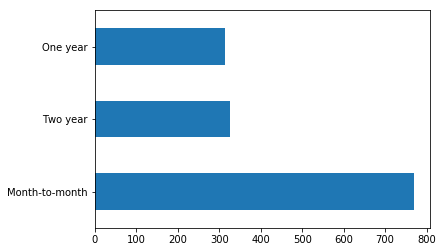

In [28]:
# Create a barplot of the value_counts of `Contract` variable
x.Contract.value_counts().plot.barh();

### Actual Churn, our churn prediction, and the prediction standard deviation for all Contract types

Group by `Contract` to see our prediction average, the standard deviation of our predictions, and the actual Churn average. 

In [29]:
flds = ['Contract', 'Churn', 'pred', 'pred_std']
contract_summary = x[flds].groupby('Contract', as_index=False).mean()
contract_summary

,Contract,Churn,pred,pred_std
0,Month-to-month,0.438231,0.408075,0.140022
1,One year,0.111821,0.113207,0.074318
2,Two year,0.033639,0.045034,0.032905


### Percentage of churn for each value of `Contract`.

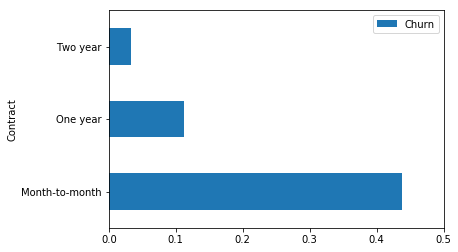

In [30]:
contract_summary = contract_summary[~pd.isnull(contract_summary.Churn)]
contract_summary.plot('Contract', 'Churn', 'barh', xlim=(0,0.5));

### Plot our predictions with confidence intervals

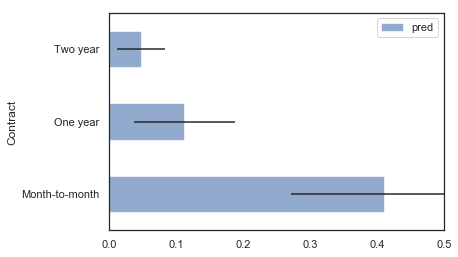

In [472]:
contract_summary.plot('Contract', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,0.5));

### **Contract Variable Interpretation**

The Contract value we are the least confident about is `Month-to-month`. This is because as we can see in the `contract_summary` DataFrame, its standard deviation is the highest among the 3 values at 0.13845. 

**Hypothesis**: 

Why is our confidence low when we have a lot of examples (almost 800) to train on for this particular feature? Our Random Forest is not able to accurately predict someone with a `Month-to-month` because the percentage of churned customers with this feature is high at 43%. There is a lot of variability and interactions happening making it difficult to predict. More work should be done understand this feature.  

## Feature Analysis: MultipleLines

### MultipleLines type barplot

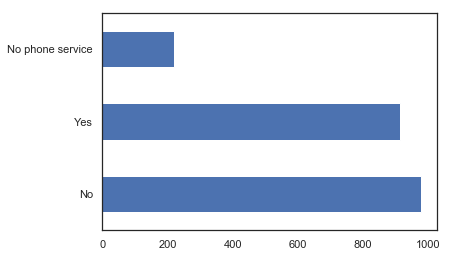

In [465]:
x.MultipleLines.value_counts().plot.barh();

### Actual Churn, our churn prediction, and the prediction standard deviation for all Line types

In [477]:
flds = ['MultipleLines', 'Churn', 'pred', 'pred_std']
MultipleLines_summary = x[flds].groupby('MultipleLines', as_index=False).mean()
MultipleLines_summary

,MultipleLines,Churn,pred,pred_std
0,No,0.248466,0.257135,0.096366
1,No phone service,0.221719,0.232029,0.113284
2,Yes,0.300875,0.267538,0.100715


### Percentage of churn for each value

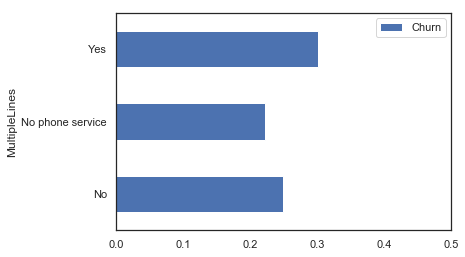

In [478]:
MultipleLines_summary = MultipleLines_summary[~pd.isnull(MultipleLines_summary.Churn)]
MultipleLines_summary.plot('MultipleLines', 'Churn', 'barh', xlim=(0,0.5));

### Plot our predictions with confidence intervals

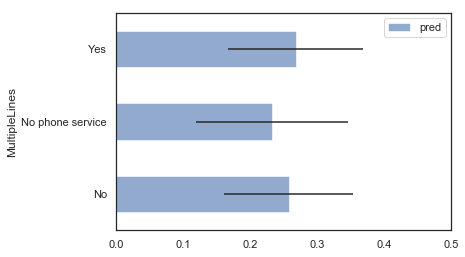

In [479]:
MultipleLines_summary.plot('MultipleLines', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,0.5));

### **MultipleLines Variable Interpretation**


We are less confident about our predictions with `No Phone Service` since its standard deviation is the highest. 


**Hypothesis**: 

This is because we don't have a lot of examples in our data to learn from this variable. As we can see in our barplot above, we only have around 200 examples with `No Phone Service`. Since not many examples exist, we cannot be very confident about this prediction.

# Conclusion

After using each of the four techniques described above, we now have a much better understanding of the important features of our data, what their relationships between them are, as well as which predictions and group of predictions we are confident about. 